# PyTransit tutorial 1

This short tutorial shows the most straightforward way to evaluate the transit light curve model for a single and multiple sets of quadratic limb darkening coefficients (LDCs). The tutorial expects the reader to understand the basic concepts of exoplanet transits as described, for example, in <a href='#Winn2010'>Winn (2010)</a> and <a href='#Perryman2011'>Perryman (2011)</a>. The details of the Giménez transit model can be found from <a href='#Gimenez2006'>Giménez (2006)</a>, and the details of the Mandel-Agol model from <a href='#MA2002'>Mandel & Agol (2002)</a>.

Working with a single set of limb darkening coefficients is common when modelling photometry observed over a single wide passband. However, both the Mandel-Agol and Gimenéz models separate the limb darkening effects from most of the numerically heavy computations. Thus, evaluating the transit model simultaneously several limb darkening coefficient sets is significantly faster than evaluating the model separately for each LDC set, which is useful in multicolour photometry and transmission spectroscopy. 

This tutorial illustrates the use of the transit model, but doesn't delve into transit modelling itself. A set of IPython notebook tutorials about Bayesian parameter estimation from transit light curves (and later RVs) can be found from my  [transit modelling tutorial repository](https://github.com/hpparvi/exo_tutorials).

## Preample

We start by importing the ``MandelAgol`` transit model, initialising sensible parameters for the transiting planet, creating a time array `t`, and initialising the quadratic limb darkening coefficient arrays `us` and `um`. Here `us` contains a single set of quadratic limb darkening coefficients, while `um` contains 10 sets.

The parameters define the orbit and the size of the planet relative to its host star, and are:

 - `k `  planet to star radius ratio
 - `t0` zero epoch
 - `p`  orbital period
 - `a`  scaled semi-major axis
 - `i`  orbital inclination
 - `e`  orbital eccentricity
 - `w`  argument of periastron
 
You wouldn't want to use this parameterisation in a real parameter estimation problem, since many of the parameters are correlated with each other. Instead, you'd use a separate sampling parametrisation that would then be mapped to this physical parameterisation.

In [1]:
%pylab inline
from pytransit import MandelAgol as MA

rc('font', size=12)

Populating the interactive namespace from numpy and matplotlib


In [2]:
k, t0, p, a, i, e, w = 0.1, 1., 4., 8., 0.5*pi, 0.01, 0.5*pi
t = linspace(0.9,1.1,500)

us = [0.4,0.1]
um = array([[0.04*iu, 0.025*iu] for iu in range(10)])

## Basic model usage

Create an instance of the transit model, accept the default values

In [3]:
md = MA()

and evaluate the model for the two cases of limb darkening coefficient sets

In [4]:
fs = md.evaluate(t, k, us, t0, p, a, i, e, w)
fm = md.evaluate(t, k, um, t0, p, a, i, e, w)

The model returns an array of normalised flux values. A single set of limb darkening coefficients results in a 1D array, while multiple sets results in 2D array.

In [5]:
print (fs.shape)
print (fm.shape)

(500,)
(500, 10)


The `MandelAgol.evaluate` method offers a direct way for the calculation of the light curve as a function of time `t`. It uses a circular 
orbit model if eccentricity is close to zero (smaller than 1e-5), and slower eccentric orbit model with non-zero eccentricities.

The `MandelAgol.__call__` method offers a way to evaluate the transit model as a function of normalised projected distance `z`. This is useful
if we don't want to recalculate the orbit but change the limb darkening coefficients or contamination factor, or if we have a better (faster)
method for the calculation of `z` than provided by the package.

Plot the light curves
---------------------

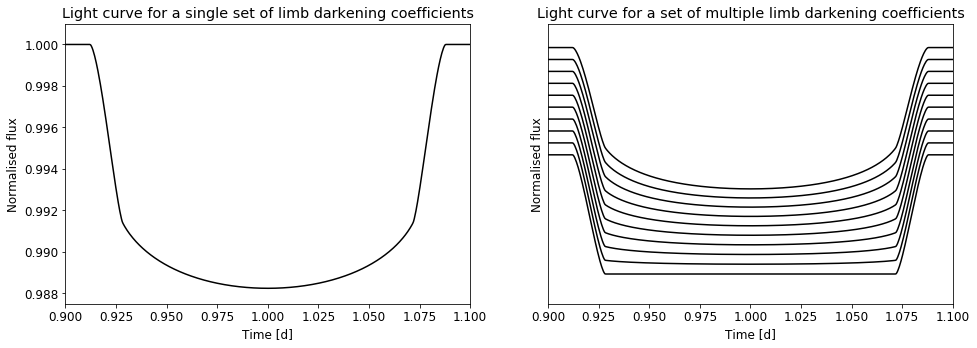

In [6]:
fig,ax = subplots(1,2,figsize=(14,5))
ax[0].plot(t,fs, 'k')
ax[1].plot(t,fm + np.arange(um.shape[0])*0.001, 'k')
setp(ax[0], ylim=(0.9875,1.001), xlabel='Time [d]', ylabel='Normalised flux', 
        title='Light curve for a single set of limb darkening coefficients')
setp(ax[1], ylim=(0.9875,1.011), yticks=[], xlabel='Time [d]', ylabel='Normalised flux', 
        title='Light curve for a set of multiple limb darkening coefficients')
setp(ax, xlim=(0.9, 1.1))
fig.tight_layout()
fig.savefig('model_example_1.png')

## Interpolation

Both models can be used in an interpolated mode, which can significantly decrease the evaluation time. The interpolated mode is used by initialising the model with ``inteprolate=True`` and (for the MA model) giving the radius ratio limits as ``klims=(kmin,kmax)``.

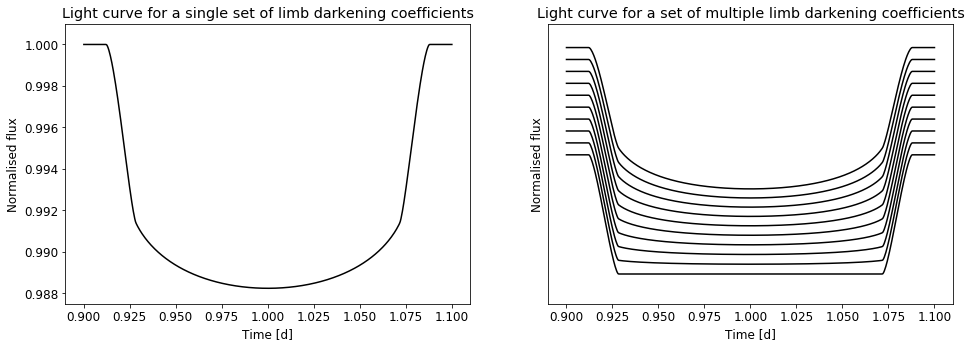

In [7]:
mi = MA(interpolate=True, klims=(0.09,0.11), nthr=4)

fs = mi.evaluate(t, k, us, t0, p, a, i, e, w)
fm = mi.evaluate(t, k, um, t0, p, a, i, e, w)

fig,ax = subplots(1,2,figsize=(14,5))
ax[0].plot(t,fs, 'k');
ax[1].plot(t,fm + np.arange(um.shape[0])*0.001, 'k');
setp(ax[0], ylim=(0.9875,1.001), xlabel='Time [d]', ylabel='Normalised flux', 
        title='Light curve for a single set of limb darkening coefficients');
setp(ax[1], ylim=(0.9875,1.011), yticks=[], xlabel='Time [d]', ylabel='Normalised flux', 
        title='Light curve for a set of multiple limb darkening coefficients');
fig.tight_layout()
fig.savefig('model_example_1_ip.png')

## Supersampling

The photometric "points" we're modelling are always integrations over time. Long exposure times lead to blurring of features, and this must be accounted for in the modelling. Supersampling offers one simple approach to this: the model is averaged over ``n`` time samples inside each exposure.  

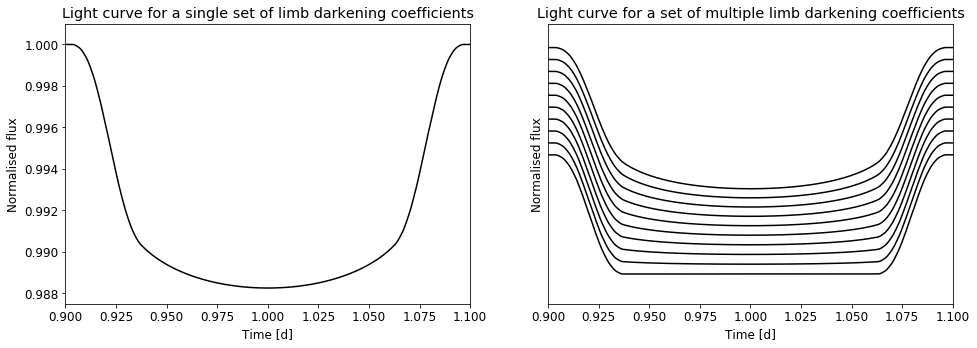

In [8]:
ms = MA(interpolate=True, klims=(0.09,0.11), nthr=4, supersampling=6)
fs = ms.evaluate(t, k, us, t0, p, a, i, e, w)
fm = ms.evaluate(t, k, um, t0, p, a, i, e, w)

fig,ax = subplots(1,2,figsize=(14,5))
ax[0].plot(t,fs, 'k');
ax[1].plot(t,fm + np.arange(um.shape[0])*0.001, 'k');
setp(ax[0], ylim=(0.9875,1.001), xlabel='Time [d]', ylabel='Normalised flux', 
        title='Light curve for a single set of limb darkening coefficients');
setp(ax[1], ylim=(0.9875,1.011), yticks=[], xlabel='Time [d]', ylabel='Normalised flux', 
        title='Light curve for a set of multiple limb darkening coefficients');
setp(ax, xlim=(0.9,1.1))
fig.tight_layout()
fig.savefig('model_example_1_in.png')

## References

<a id="Winn2010">1.</a> <a href="http://arxiv.org/abs/1001.2010">Winn, J. N. in EXOPLANETS (Seager, S.) (University of Arizona Press, 2010).</a>

<a id="Perryman2011">2.</a> <a href="http://www.cambridge.org/us/academic/subjects/astronomy/extrasolar-planets-and-astrobiology/exoplanet-handbook">Perryman, M. <cite>The Exoplanet Handbook</cite>. 424 (Cambridge University Press, 2011).</a>

<a id="Gimenez2006">3.</a> <a href="http://adsabs.harvard.edu/abs/2006A&A...450.1231G">Giménez, A. Equations for the analysis of the light curves of extra-solar planetary transits. A&A 450, 1231–1237 (2006).</a>

<a id="MA2002">4.</a> <a href="http://adsabs.harvard.edu/abs/2002ApJ...580L.171M">Mandel, K. & Agol, E. Analytic Light Curves for Planetary Transit Searches. ApJ 580, L171–L175 (2002).</a>